##### This is a script that trains a 3D-Unet model on a downsampled unprocessed HCP 7T resting state fMRI dataset.

Unet implementation by Adrian Wolney is used: https://github.com/wolny/pytorch-3dunet 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import json

import torch as t
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
# 3D-UNet model imported here, path need to be included
from pytorch3dunet.unet3d import model

from dataset_management import LS_dataset_subj, LS_dataset_subjSave
from utils_LS.Unet_LS_trainers import train_and_eval, take_a_look, test_set_recon_n_save


t_seed = t.manual_seed(2112)
n_seed = random.seed(0)
np_seed = np.random.seed(0)

device = t.device("cuda" if t.cuda.is_available() else "cpu")
dtype_pt = t.float32
print(device)

TRAIN_INPUT_PATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Training_data/LS_imgs'
TRAIN_LABEL_PATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Training_data/Original_fMRI'

TEST_INPUT_PATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Testing_data/LS_imgs'
TEST_LABEL_PATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Testing_data/Original_fMRI'


EPOCHS = 20

cuda


### 1. Defining datasets

In [6]:
total_data = LS_dataset_subj(TRAIN_LABEL_PATH, TRAIN_INPUT_PATH)

Datasets = random_split(total_data, [0.9397, 0.0603], generator=t.Generator().manual_seed(2112))

train_set = DataLoader(Datasets[0], batch_size=4, shuffle=True, num_workers=2)
val_set = DataLoader(Datasets[1], batch_size=1, shuffle=False, num_workers=2)

### 2. Defining model, optimizer, loss function and starts the training

Training time: 5422 min

In [3]:
t.manual_seed(2112)


Unet3D = model.UNet3D(in_channels=1, out_channels=1, num_groups=2, is_segmentation=False)
Unet3D.to(device=device, dtype=dtype_pt)

optimizer = t.optim.Adam(Unet3D.parameters(), lr=5e-5, amsgrad=True)

loss_fn = nn.MSELoss()

train_loss, val_loss, val_hists = train_and_eval(
                                EPOCHS, 
                                train_set, 
                                val_set, 
                                Unet3D, 
                                optimizer, 
                                loss_fn,
                                device,
                                num_augment=2,
                                model_savename='Unet3D_unproc_optim.pt')

Validating Epoch 20: 100%|████████████████████████████████████████| 10/10 [09:13<00:00, 55.32s/batch, loss=1.19]


In [4]:
t.save(Unet3D.state_dict(), 'Unet3D_unproc_20ep.pt')

In [5]:
import json

unproc_train_metrics = {'train loss': train_loss, 
                        'val loss':val_loss, 
                        'val hists': val_hists}

    
with open("train_metrics_unproc.json", "w") as outfile:
    json.dump(unproc_train_metrics, outfile)

### 3. Visualizing losses

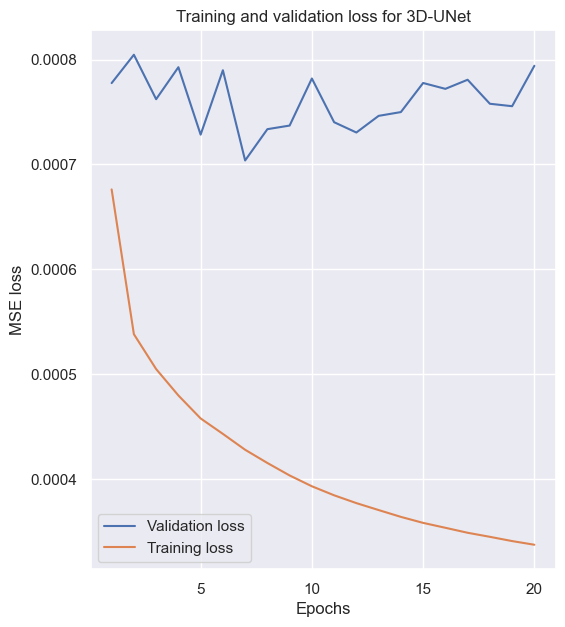

In [5]:
import seaborn as sns
sns.set()

with open('train_metrics/train_metrics_unproc.json') as json_file:
            train_metrics = json.loads(json_file.read())

x_ax = range(1, EPOCHS+1)

plt.figure(figsize=(6,7))
plt.plot(x_ax, [this_loss/(10*50*3) for this_loss in train_metrics["val loss"]], label='Validation loss')
plt.plot(x_ax, [this_loss/(156*50*3) for this_loss in train_metrics["train loss"]], label='Training loss')


plt.xlabel("Epochs")
plt.locator_params(axis="x", integer=True, tight=True)
plt.ylabel("MSE loss")
plt.title('Training and validation loss for 3D-UNet')
plt.legend()
plt.show()

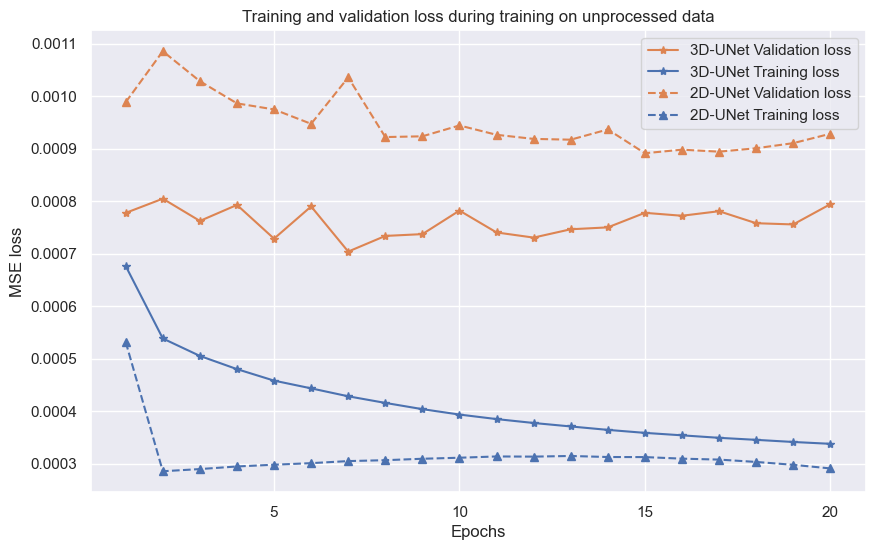

In [32]:
import seaborn as sns
sns.set()

with open('train_metrics/train_metrics_unproc.json') as json_file:
            train_metrics_3D = json.loads(json_file.read())

with open('C:/Users/MariusER/Documents/GitHub/Master-Project-LoopingStar/DL_training_py/2D-UNet/train_metrics/UNet2D-train_metrics_1e3.json') as json_file:
            train_metrics_2D = json.loads(json_file.read())

plt.figure(figsize=(10,6))


x_ax = range(1, EPOCHS+1)

plt.plot(x_ax, [this_loss/(10*50*3) for this_loss in train_metrics_3D["val loss"]], label='3D-UNet Validation loss', marker='*', color='C1')
plt.plot(x_ax, [this_loss/(156*50*3) for this_loss in train_metrics_3D["train loss"]], label='3D-UNet Training loss', marker='*', color='C0')
plt.plot(x_ax, [this_loss/(10*50*2) for this_loss in train_metrics_2D["val_loss"]], '--', label='2D-UNet Validation loss', marker='^', color='C1')
plt.plot(x_ax, [this_loss/(156*50*2) for this_loss in train_metrics_2D["train_loss"]], '--', label='2D-UNet Training loss', marker='^', color='C0')


plt.xlabel("Epochs")
plt.locator_params(axis="x", integer=True, tight=True)
plt.ylabel("MSE loss")
plt.title('Training and validation loss during training on unprocessed data')
plt.legend()
plt.show()

### 4. Looking at reconstruction results

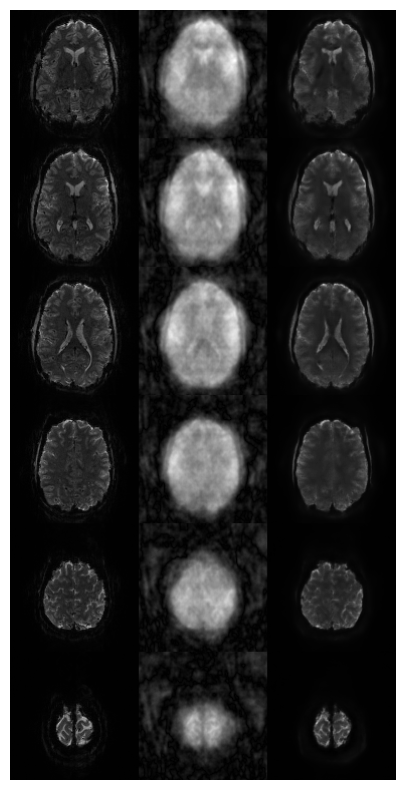

In [4]:
Unet3D = model.UNet3D(in_channels=1, out_channels=1, num_groups=2, is_segmentation=False)
Unet3D.load_state_dict(t.load('C:/Users/MariusER/Documents/GitHub/Master-Project-LoopingStar/DL_training_py/3D-Unet/Unet3D_unproc_optim.pt'))

take_a_look(Unet3D, val_set, device, subindex = 0)

### 5. Saving image files of reconstructed fMRI image series

In [4]:
SAVEPATH = 'E:/Master_Project_Marius/Unprocessed_HCP_data/Testing_data/DL_recon/3D-UNet'

total_data_test = LS_dataset_subjSave(TEST_INPUT_PATH)
test_set = DataLoader(total_data_test, batch_size=1, shuffle=False)

test_set_recon_n_save(Unet3D, test_set, device, SAVEPATH, '_Unproc_UNet_recon.nii')

Subject 654552: 100%|██████████| 900/900 [05:14<00:00,  2.86volume/s]
